# Spectral difference method

Finite Element Method

In [1]:
%pylab inline
from timeit import default_timer as timer
rcParams.update({'font.size': 15})
rcParams.update({'figure.figsize': (7,5)})

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


We devide the domain in Cartesian elements.

We define a set of $p+1$ solution points $S=\left( x_0^s, x_1^s...x_p^s\right)$

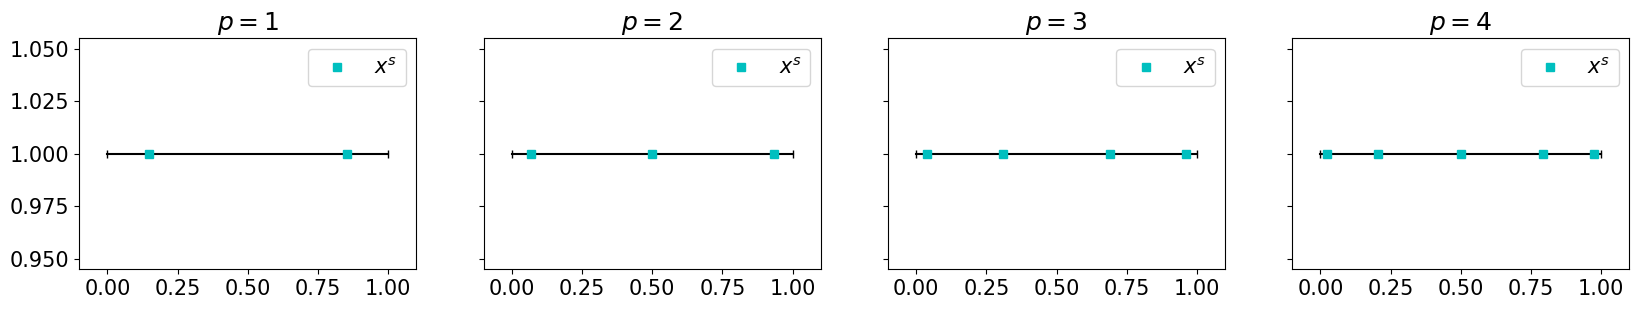

In [2]:
def solution_points(
    x1: float,
    x2: float,
    p: int,
) -> np.ndarray:
    """
    Return `n + 1` Chebyshev-like points on the [`x1`, `x2`] interval.

    They therefore lie between corresponding points of the `p`th degree
    Gauss-Legendre quadrature together with the bounds.
    """
    i = np.arange(p + 1)
    return x1 + (1.0 - np.cos((2*i + 1)/(2*(p + 1))*np.pi))*(x2 - x1)/2.0

fig,axs = subplots(1,4,figsize=(20,3),sharey=True)
for i in range(4):
    p=i+1
    sca(axs[i])
    plot([0,1],[1,1],"|-",color="k")
    plot(solution_points(0,1,p),np.ones(p+1),"s",color="c",label=r"$x^s$")
    title(f'$p={i+1}$')
    xlim(-.1,1.1)
    legend()

We define a set of p+2 flux points $F=\left( x_0^f, x_1^f...x_p^f\right)$

To ensure stability, the flux points are the Gauss-Legendre quadrature points + the two end points of the element

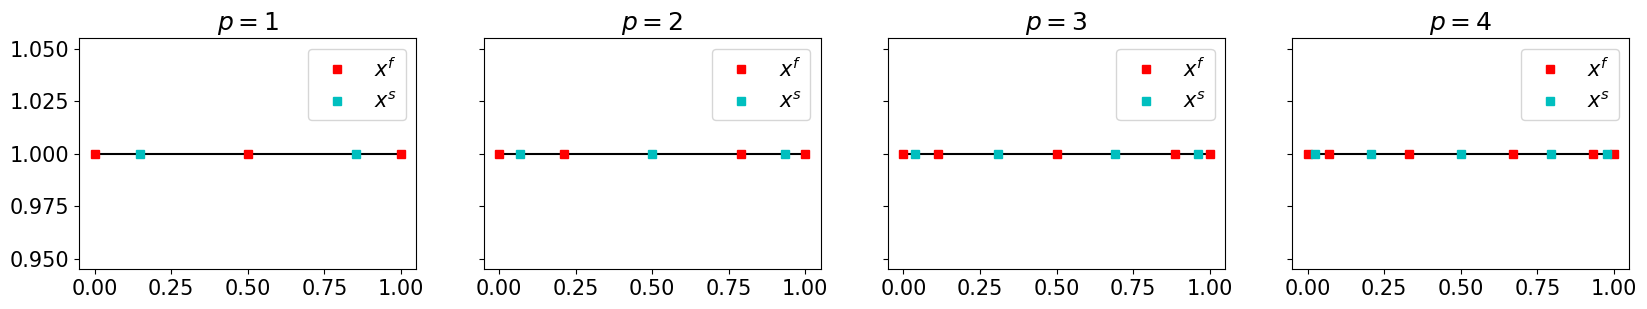

In [3]:
def gauss_legendre_quadrature(
    x1: float,
    x2: float,
    p: int,
):
    """
    Return `p` points and weights from the `p`th degree
    Gauss-Legendre quadrature on the interval [`x1`, `x2`].
    """
    if p == 0:
        return np.ndarray(0), np.ndarray(0)
    x, w = np.polynomial.legendre.leggauss(p)
    return x1 + (x + 1.0)*(x2 - x1)/2.0, w*(x2 - x1)/2.0

def flux_points( 
    x1: float,
    x2: float,
    p: int,
)->np.ndarray:
    """
    Return `p+2` points from the `p`th degree
    Gauss-Legendre quadrature on the interval [`x1`, `x2`].
    """
    x_fp = gauss_legendre_quadrature(0,1,p)[0]
    return np.hstack((0.0, x_fp, 1.0))
    
fig,axs = subplots(1,4,figsize=(20,3),sharey=True)
for i in range(4):
    p=i+1
    sca(axs[i])
    plot([0,1],[1,1],"|-",color="k")
    plot(flux_points(0,1,p),np.ones(p+2),"s",color="red",label=r"$x^f$")
    plot(solution_points(0,1,p),np.ones(p+1),"s",color="c",label=r"$x^s$")
    title(f'$p={i+1}$')
    legend()

The solution inside the element is given by Lagrange polynomials of degree p

$u(x,t) = \sum_i^p u(t) \ell_i^s(x)$

The flux inside the element is given by Lagrange polynomials of degree p+1:

$f(x,t) = \sum_i^{p+1} f(t) \ell_i^f(x)$

The Lagrange polynomials are

$\ell_i (x) = \prod_{\substack{j=0\\j\ne i}}^{p}\frac{x-x_i}{x_j-x_i}$


$\ell_i (x_j) = \delta_{ij},\quad \psi(x)=\sum_{i=0}^p \psi(x_i) \ell_i (x) $

In [4]:
def lagrange_matrix(
    x_to: np.ndarray,
    x_from: np.ndarray,
) -> np.ndarray:
    """
    Return an (m, n) matrix mapping values defined on n points `x_from` to values
    defined on m points `x_to`, using Lagrange interpolation.

    For some elementwise scalar function ``f``, ``f(x_to) \\approx LM f(x_from)``.
    """
    assert len(x_to.shape) == 1, "x_to must be 1D."
    assert len(x_from.shape) == 1, "x_from must be 1D."
    num = np.broadcast_to(
        x_to[:, np.newaxis, np.newaxis] - x_from[np.newaxis, np.newaxis, :],
        (x_to.shape[0], x_from.shape[0], x_from.shape[0]),
    ).copy()
    num[:, np.arange(x_from.shape[0]), np.arange(x_from.shape[0])] = 1.0
    den = x_from[:, np.newaxis] - x_from[np.newaxis, :]
    np.fill_diagonal(den, 1.0)
    return num.prod(axis=-1)/den.prod(axis=-1)[np.newaxis, :]

p=1
x_fp = flux_points(0.0, 1.0, p)
x_sp = solution_points(0.0, 1.0, p)
"Lagrange matrix to interpolate from solution to flux points"
sp_to_fp = lagrange_matrix(x_fp, x_sp)
"Lagrange matrix to interpolate from flux to solution points"
fp_to_sp = lagrange_matrix(x_sp, x_fp)

We define the Lagrange matrix

$L^{s,f}_{ij} = \ell^s_j(x^f_i)$

that allows to interpolate from solution points to flux points

$u(x^f_i,t)= L^{s,f}_{ij} u(x^s_j,t)$

### Divergence of the flux
We compute the divergence of the flux at the solution points and update u as: 

$d_t u_i =- \sum_{j=0}^{p+1} f_j(t) \ell_j^{\prime f}(x_i^s)$ 

where $\ell^{\prime}$ is the derivative of the Lagrange polynomials.

In [5]:
def lagrangeprime_matrix(
    x_to: np.ndarray,
    x_from: np.ndarray,
) -> np.ndarray:
    """
    Return an (m, n) matrix of first derivatives of lagrange polynomials defined
    on n points `x_from` evaluated on m points `x_to`.
    """
    assert len(x_to.shape) == 1, "x_to must be 1D."
    assert len(x_from.shape) == 1, "x_from must be 1D."
    num = np.broadcast_to(
        x_to[:, np.newaxis, np.newaxis, np.newaxis] - x_from[np.newaxis, np.newaxis, np.newaxis, :],
        (x_to.shape[0], x_from.shape[0], x_from.shape[0], x_from.shape[0]),
    ).copy()
    a = np.arange(x_from.shape[0])
    num[:, a, :, a] = 1.0
    num[:, :, a, a] = 1.0
    den = x_from[:, np.newaxis] - x_from[np.newaxis, :]
    np.fill_diagonal(den, 1.0)
    p = num.prod(axis=-1)/den.prod(axis=-1)[np.newaxis, :, np.newaxis]
    p[:, a, a] = 0.0
    return p.sum(axis=-1)

"Matrix to perform derivative from flux to solution point"
dfp_to_sp = lagrangeprime_matrix(x_sp, x_fp)

Matrix to perform derivative from flux to solution point

$L'^{f,s}_{ij} = \ell'^f_j(x^s_i)$

The update for $u$ at solution points $\{x^s\}$ is then computed as:

$u(x^s_i,t+\Delta t) = u(x^s_i,t)- L'^{f,s}_{ij} f(x^f_j,t) \Delta t/h$



In [6]:
def intfromsol_matrix(
    x_sp: np.ndarray,
    x_fp: np.ndarray,
) -> np.ndarray:
    """
    Return an (m, m) matrix to transform values defined on m points `x_sp` to mean values defined
    on m control volumes bounded by m + 1 points `x_fp`.
    """
    assert len(x_sp.shape) == 1, "x_sp must be 1D."
    assert len(x_fp.shape) == 1, "x_fp must be 1D."
    m = x_fp.shape[0] - x_sp.shape[0]
    n = x_sp.shape[0] - 1
    if n == 0:
        return np.ones((1, 1))
    x, w = gauss_legendre_quadrature(0.0, 1.0, n)
    xi = (x_fp[:-1, np.newaxis] + np.diff(x_fp)[:, np.newaxis]*x[np.newaxis, :]).ravel()
    lm = lagrange_matrix(xi, x_sp).reshape(n + m, n, n + 1)
    return np.einsum("ijk,j->ik", lm, w)

"Matrix to compute mean values in control volumes from values at solution pts."
sp_to_cv = intfromsol_matrix(x_sp, x_fp)
"Inverse matrix to compute values at solution points from control volume averages"
cv_to_sp = np.linalg.inv(sp_to_cv)

Matrix to compute control volume averages $\bar{u}$ at control volume centers $\{x^c\}$ from $\{u(x^s)\}$:

$\bar{u}(x_i^c) = I^{c,s}_{ij}u(x^s_j)$

The inverse of this Matrix can then be used to compute $\{u(x^s)\}$ from  $\{\bar{u}(x^c)\}$:

$u(x_i^s) = I^{-1 s,c}_{ij}\bar{u}(x^c_j)$

In [7]:
def quadrature_mean(
    mesh: np.ndarray,
    fct,
    v: int,
) -> np.ndarray:
    """
    Return an array containing mean values of `fct` inside mesh control volumes.
    Means are calculated with a Gauss-Legendre quadrature of degree p.
    """
    p = mesh.shape[-1] - 1
    na = np.newaxis
    x, w = gauss_legendre_quadrature(0.0, 1.0, p)
    pts = np.ndarray(( mesh.shape[0], p, p))
    
    pts[...] = mesh[:,:-1,na] + x[na,na,:]*np.diff(mesh,axis=-1)[:,:,na]
    return np.einsum("x,ikx->ik",w,fct(pts,v))

def sinus(x: np.ndarray,ivar) -> np.ndarray:
    if ivar==0:
        return np.cos(2.0*np.pi*x)
    elif ivar==1:
        return np.ones(x.shape)
N=10   
mesh_cv = (np.arange(N).reshape(N,1) + x_fp.reshape(1,p+2))/N
u_cv = quadrature_mean(mesh_cv,sinus,0)

The initial condition is obtained by evaluating the function in p+1 points inside each control-volume. Then, we compute the control-volume average by integrating over the p+1 basis inside each control-volume. This allows for the solution inside the element to be continuos, and represented by the proper polynomial basis.

In [8]:
"N(p+1)+1 faces in [0,1]"
x_faces = 1/N*np.hstack((np.arange(N).repeat(p+1)+np.tile(x_fp[:-1],N),N))
"N(p+1) control volume centers"
x_centers = 0.5*(x_faces[1:]+x_faces[:-1])

Text(0.5, 1.0, '$p=1,N=10$')

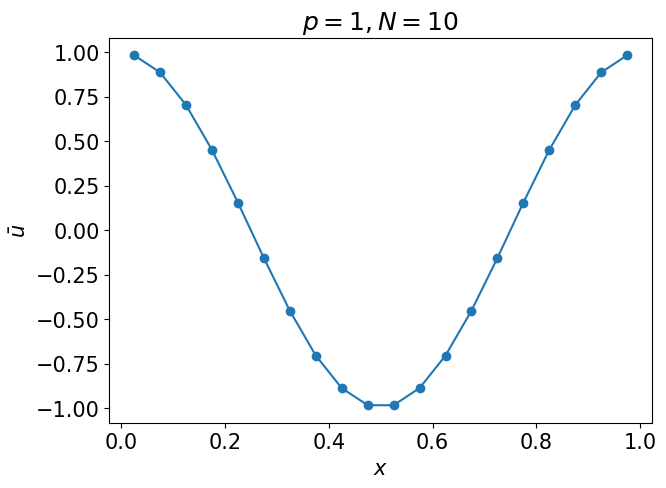

In [9]:
def squash_dimensions(U):
    "(N,p+1)->N(p+1)"
    return U.reshape(U.shape[0]*U.shape[1])
plot(x_centers,squash_dimensions(u_cv),"-o")
xlabel(r'$x$')
ylabel(r'$\bar{u}$')
title(f'$p={p},N={N}$')

Now we compute the solution at $\{x^s\}$ from the control volume averages ($\bar{u}$):\
$u(x^s_i,t)= I^{-1s,c}_{ij} \bar{u}(x^c_j,t)$

In [10]:
u_sp = np.einsum("sv,iv->is", cv_to_sp, u_cv)

In [11]:
x_sol = (np.tile(x_sp,N)+arange(N).repeat(p+1))/N

Text(0.5, 1.0, '$p=1,N=10$')

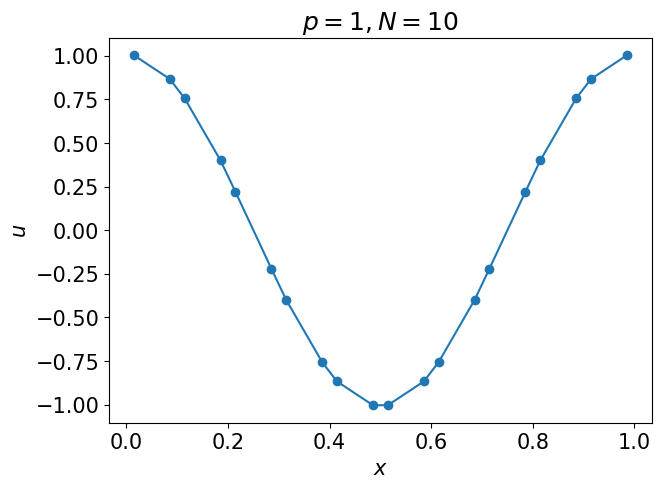

In [12]:
plot(x_sol,squash_dimensions(u_sp),"o-")
xlabel(r'$x$')
ylabel(r'$u$')
title(f'$p={p},N={N}$')

We can go back to $\{ \bar{u} \{x^c\} \}$ from $\{u \{x^s\} \}$:\
$\bar{u}(x^c_i,t)= I^{c,s}_{ij} u(x^s_j,t)$

Text(0.5, 1.0, '$p=1,N=10$')

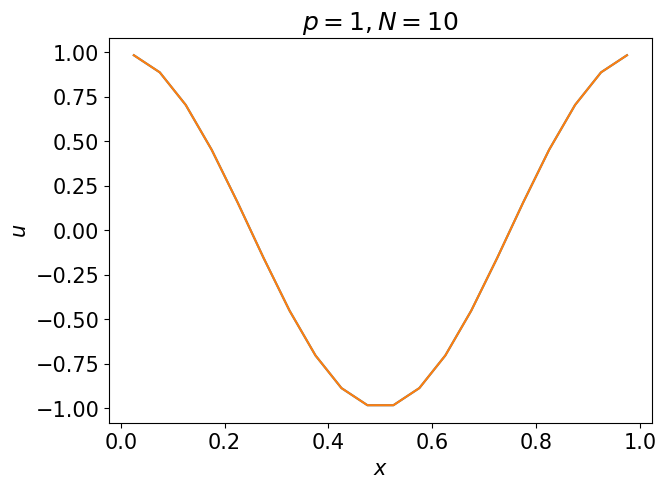

In [13]:
# We plot both the initial u_cv and the u_cv obtained from u_sp
plot(x_centers,squash_dimensions(u_cv))
u_cv = np.einsum("vs,cs->cv", sp_to_cv, u_sp)
plot(x_centers,squash_dimensions(u_cv))
xlabel(r'$x$')
ylabel(r'$u$')
title(f'$p={p},N={N}$')

We can also compute the solution at $\{x^f\}$ from $\{u(x^s)\}$:\
$u(x^f_i,t)= L^{f,s}_{ij} u(x^s_j,t)$

In [14]:
#Array for the N(p+2) flux points
x_flux = (np.tile(x_fp,N)+arange(N).repeat(p+2))/N

Text(0.5, 1.0, '$p=1,N=10$')

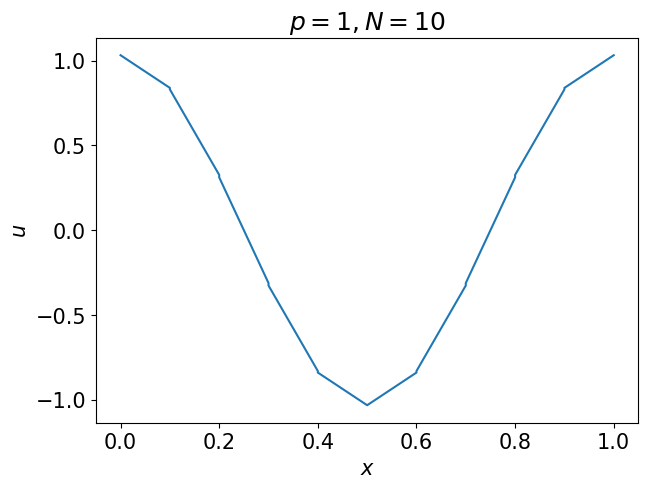

In [15]:
u_fp = np.einsum("fs,is->if", sp_to_fp, u_sp)
plot(x_flux,squash_dimensions(u_fp),"-")
xlabel(r'$x$')
ylabel(r'$u$')
title(f'$p={p},N={N}$')

As we can see, there are discontinuities between elemets. It is therefore necessary to solve a Riemann problem at these interfaces

Text(0.5, 1.0, '$p=1,N=10$')

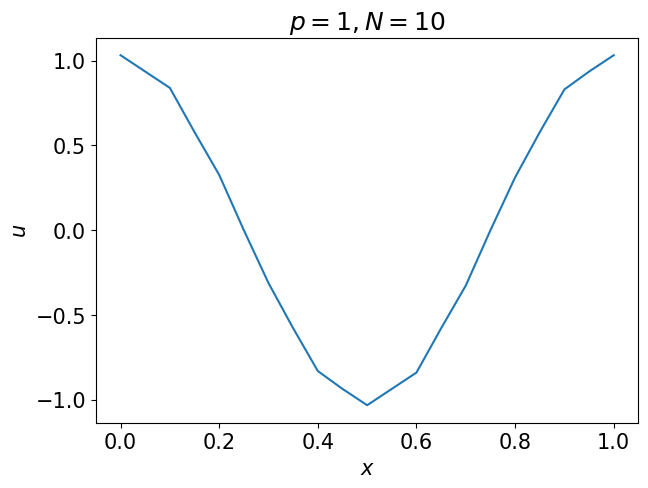

In [16]:
def solve_riemann(
    U_L: np.ndarray,
    U_R: np.ndarray,
    vel: np.ndarray,
    roll_axis: int,
    *args,
    **kwargs,
) -> None:
    U_R[...] = np.where(
        vel > 0,
        np.roll(U_L, 1, axis=roll_axis),
        U_R,
    )
    U_L[...] = np.roll(U_R, -1, axis=roll_axis)
                
#Let's solve for periodic boundaries
# At interfaces between elements we have
# u_L | u_R
# u_L -> last value of each element
# u_R -> first value of each elemet

u_fp = np.einsum("fs,is->if", sp_to_fp, u_sp)
solve_riemann(u_fp[:,-1], u_fp[:, 0], 1, -1)

plot(x_flux,squash_dimensions(u_fp))
xlabel(r'$x$')
ylabel(r'$u$')
title(f'$p={p},N={N}$')

In [17]:
class SD_Simulator:
    def __init__(
        self,
        init_fct,
        p: int = 8,
        N: int = 32,
        riemann_solver_fct = solve_riemann,
        cfl_coeff: float = 0.8,
        dimension: int = 1,
    ):
        self.p = p
        self.N = N
        self.riemann_solver_fct = riemann_solver_fct
        self.init_fct = init_fct
        self.dimension = dimension
        self.cfl_coeff = cfl_coeff
       
        self.dx = 1.0/self.N
        self.time = 0
        self.n_step = 0

        self.x_fp = flux_points(0.0, 1.0, p)
        self.x_sp = solution_points(0.0, 1.0, p)
        
        self.mesh_cv = (np.arange(N).reshape(N,1) + self.x_fp.reshape(1,p+2))/N
        self.x_faces = 1/N*np.hstack((np.arange(N).repeat(p+1)+np.tile(self.x_fp[:-1],N),N))  
        self.x_centers = 0.5*(self.x_faces[1:]+self.x_faces[:-1])

        # Values at flux pts from values at sol pts.
        self.sp_to_fp = lagrange_matrix(self.x_fp, self.x_sp)
        # Spatial derivative of the flux at sol pts from density at flux pts.
        self.dfp_to_sp = lagrangeprime_matrix(self.x_sp, self.x_fp)
        # Mean values in control volumes from values at sol pts.
        self.sp_to_cv = intfromsol_matrix(self.x_sp, self.x_fp)
        self.cv_to_sp = np.linalg.inv(self.sp_to_cv)

        self.post_init()
        self.compute_dt()

    def post_init(self) -> None:
        self.U_init_cv = quadrature_mean(self.mesh_cv, self.init_fct, 0)
        self.velocity_fp = self.init_fct(self.mesh_cv,1)
        self.U_init_sp = self.compute_sp_from_cv(self.U_init_cv)

        # Final solution at the current time.
        self.U_cv = self.U_init_cv.copy()
        self.U_sp = self.U_init_sp.copy()

    def compute_sp_from_cv(self,U_cv) -> None:
        # Axes labels:
        #   c: cells
        #   s: sol pts
        #   v: control volumes
        return np.einsum("sv,cv->cs", self.cv_to_sp, U_cv)

    def compute_cv_from_sp(self,U_sp) -> None:
        # Axes labels:
        #   c: cells
        #   s: sol pts
        #   v: control volumes
        return  np.einsum("vs,cs->cv", self.sp_to_cv, U_sp)
        
    def compute_dt(self) -> None:
        v_max = np.max(self.velocity_fp)
        self.dt = self.cfl_coeff*self.dx/v_max/(self.p + 1)  
        return self.dt

In [18]:
s = SD_Simulator(p=3,N=10,init_fct=sinus)

In [19]:
def plot_solution(s,**kwargs):
    U = squash_dimensions(s.U_cv)
    plot(s.x_centers,U,**kwargs)
    xlabel(r'$x$')
    ylabel(r'$\bar{u}$')
    title(f'$t={round(s.time,2)}$')

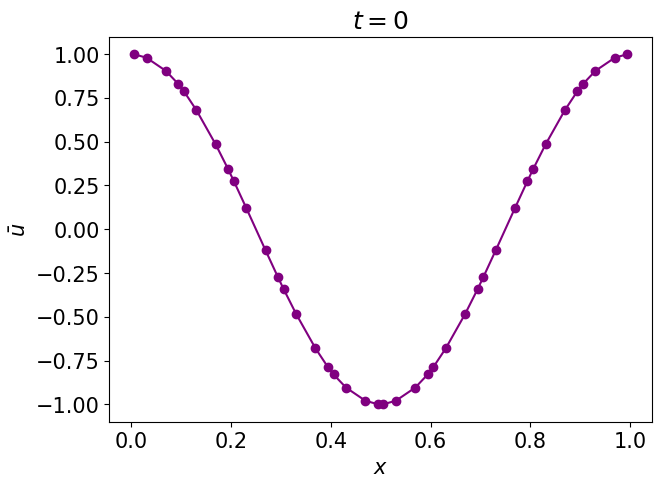

In [20]:
plot_solution(s,marker="o",color="purple")

## Time integration 

Here we will make use of the ADER method for time integration (Dumbser et al. 2008, Zanotti et al. 2015), an arbitrarily high order method in time.\
In this method the time is discretized in $(p+1)$ time quadrature points. 

The solution is represented using Lagrange polynomials in time $\ell_i(t)$ defined on $(p+1)$ Legendre quadrature points $\lbrace t_i \rbrace_{i=0}^p \in [0,\Delta t]$:

$u(t) = \sum_{i=0}^p u^i \ell_i(t)$

We can write the ADER method as:
$M\mathbf{u}=r(\mathbf{u})$

Leads to a $(p+1)\times(p+1)$ implicit system of equations.

We use an iterative procedure to solve the problem for each time step

$\mathbf{u}_{k} = M^{-1} r (\mathbf{u}_{k-1}), \quad k = 0, ..., p$

with $\lbrace u^{0}_k=u(t)\rbrace_{k=0}^p$

Final predicted state $\lbrace u^{p}_k \rbrace_{k=0}^p$

Update: $u(t + \Delta t) = u(t) + \Delta t \sum_{i=0}^p w_{i} {\cal L}(u^{p}_i)$.

The Courant condition for stability go the SD scheme (Vanharen et al. 2017) is:

$\Delta t = \frac{C}{p+1} \frac{h}{|v_{\rm max}|}$

In [21]:
def ader_matrix(
    x_time: np.ndarray,
    w_time: np.ndarray,
    dt: float,
) -> np.ndarray:
    """
    Return the ADER (n, n) matrix defined using the n `x_time` points and `w_time` weigths on the [0, dt] interval.
    """
    assert len(x_time.shape) == 1, "x_time must be 1D."
    assert len(w_time.shape) == 1, "w_time must be 1D."
    assert x_time.shape == w_time.shape, "x_time and w_time shapes must match."
    ltm = lagrange_matrix(np.array([dt]), x_time).ravel()
    lpm = lagrangeprime_matrix(x_time, x_time)
    return ltm[np.newaxis, :]*ltm[:, np.newaxis] - lpm.T*w_time[np.newaxis, :]

def initialize_ader(self):
    # ADER matrix.
    # (*)
    self.x_tp, self.w_tp = gauss_legendre_quadrature(0.0, 1.0, self.p + 1)
    self.ader = ader_matrix(self.x_tp, self.w_tp, 1.0)
    self.invader = np.linalg.inv(self.ader)*self.w_tp
    # Axes:
    #   0: ADER substeps
    #   2: cells
    #   3: pts inside cells
    self.U_ader_sp = np.ndarray((self.p+1, self.N, self.p+1))
    # Solution at flux points
    self.U_ader_fp = np.ndarray((self.p+1, self.N, self.p+2))

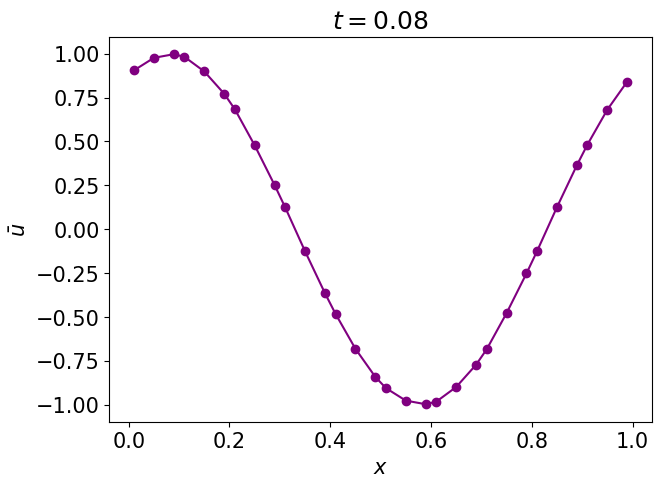

In [22]:
def perform_ader(self) -> None:
    self.n_step += 1
    na = np.newaxis
    # 1) Initialize U_ader_sp to u_sp, at all ADER time substeps.
    self.U_ader_sp[...] = self.U_sp[na,...]
    
    # 2) ADER scheme (Picard iteration).
    for ader_iter in range(self.p + 1):
        # 2a) Map sol to flux points.
        # Axes labels:
        #   f: flux pts
        #   s: sol pts
        #   t: ADER substeps
        #   i: element
        self.U_ader_fp[...] = np.einsum("fs,tis->tif", self.sp_to_fp, self.U_ader_sp)
        
        # 2b) Solve Riemann problem at cell interfaces.
        #Let's solve for periodic boundaries
        # At interfaces between elements we have
        # u_L | u_R
        # u_L -> last value of each element
        # u_R -> first value of each elemet
        self.riemann_solver_fct(self.U_ader_fp[:,:,-1],self.U_ader_fp[:,:,0], self.velocity_fp[:,0], -1)
        
        if ader_iter < self.p:
            # 2c) Compute new iteration value.
            # Axes labels:
            #   n: ADER substeps, next
            #   p: ADER substeps, prev
            #   s: sol pts
            #   f: flux pts
            #   i: element
            self.U_ader_sp = self.U_sp[na, ...] - np.einsum(
                "np,sf,pif->nis",
                self.invader,
                self.dfp_to_sp,
                self.U_ader_fp*self.velocity_fp,
            )*self.dt/self.dx
    # 3) ADER final update: weighted sum over ADER substeps.
    # Axes labels:
    #   t: ADER substeps
    #   s: sol pts
    #   f: flux pts
    #   i: element
    self.U_sp -= np.einsum(
        "t,sf,tif->is",
        self.w_tp,
        self.dfp_to_sp,
        self.U_ader_fp*self.velocity_fp,
    )*self.dt/self.dx
    self.time = self.time + self.dt
    self.U_cv[...] = self.compute_cv_from_sp(self.U_sp)

    
s = SD_Simulator(p=2,N=10,init_fct=sinus,riemann_solver_fct=solve_riemann)
initialize_ader(s)
for i in range(3):
    perform_ader(s)
plot_solution(s,marker="o",color="purple")

p=2, N=10: 19 time steps (Execution time: 0.005622 s)


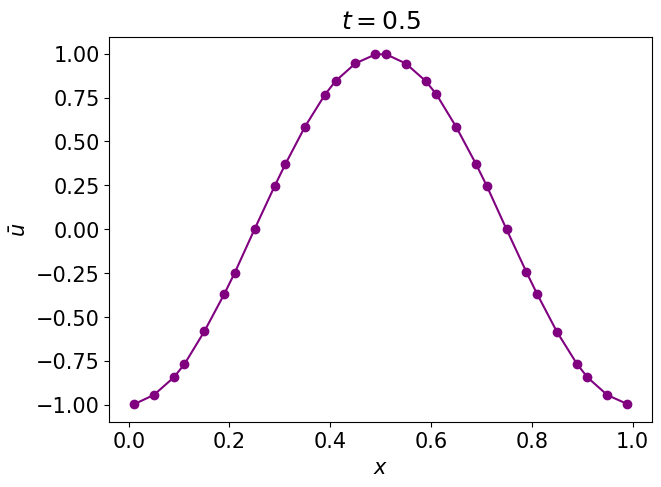

In [23]:
def perform_time_evolution(self, t_end: float) -> None:
    initialize_ader(s)
    self.execution_time = -timer()
    while(self.time < t_end):
        self.compute_dt()   
        if(self.time + self.dt >= t_end):
            self.dt = t_end-self.time
        perform_ader(self)
    self.execution_time += timer() 
    print(f"p={self.p}, N={self.N}: {self.n_step} time steps (Execution time: {round(self.execution_time,6)} s)")

s = SD_Simulator(p=2,N=10,init_fct=sinus)
perform_time_evolution(s,.5)
plot_solution(s,marker="o",color="purple")

In [24]:
from collections import defaultdict

In [25]:
sims=defaultdict(list)
for p in range(1,8):
    s = SD_Simulator(p=p,N=10,init_fct=sinus)
    perform_time_evolution(s,.5)
    sims[p] = s

p=1, N=10: 13 time steps (Execution time: 0.002659 s)
p=2, N=10: 19 time steps (Execution time: 0.005193 s)
p=3, N=10: 25 time steps (Execution time: 0.011936 s)
p=4, N=10: 32 time steps (Execution time: 0.022782 s)
p=5, N=10: 38 time steps (Execution time: 0.040726 s)
p=6, N=10: 44 time steps (Execution time: 0.072165 s)
p=7, N=10: 50 time steps (Execution time: 0.12753 s)


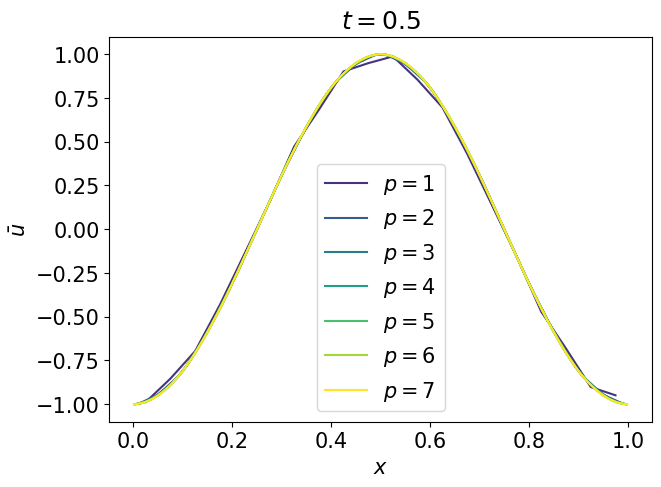

In [26]:
for p in range(1,8):
    plot_solution(sims[p],color=cm.viridis(p/7),label=f"$p={p}$")   
legend()

In [27]:
sims=defaultdict(list)
Ns=2**arange(2,8)
for p in range(1,8):
    for N in Ns:
        s = SD_Simulator(p=p,N=N,init_fct=sinus)
        perform_time_evolution(s,1)
        sims[(p,N)] = s

p=1, N=4: 11 time steps (Execution time: 0.002233 s)
p=1, N=8: 20 time steps (Execution time: 0.003669 s)
p=1, N=16: 40 time steps (Execution time: 0.006815 s)
p=1, N=32: 81 time steps (Execution time: 0.016789 s)
p=1, N=64: 161 time steps (Execution time: 0.035649 s)
p=1, N=128: 320 time steps (Execution time: 0.07845 s)
p=2, N=4: 16 time steps (Execution time: 0.004101 s)
p=2, N=8: 31 time steps (Execution time: 0.007977 s)
p=2, N=16: 60 time steps (Execution time: 0.019102 s)
p=2, N=32: 121 time steps (Execution time: 0.043701 s)
p=2, N=64: 241 time steps (Execution time: 0.093736 s)
p=2, N=128: 481 time steps (Execution time: 0.231555 s)
p=3, N=4: 20 time steps (Execution time: 0.007331 s)
p=3, N=8: 40 time steps (Execution time: 0.017819 s)
p=3, N=16: 81 time steps (Execution time: 0.039408 s)
p=3, N=32: 161 time steps (Execution time: 0.089916 s)
p=3, N=64: 320 time steps (Execution time: 0.228513 s)
p=3, N=128: 640 time steps (Execution time: 0.622559 s)
p=4, N=4: 25 time steps 

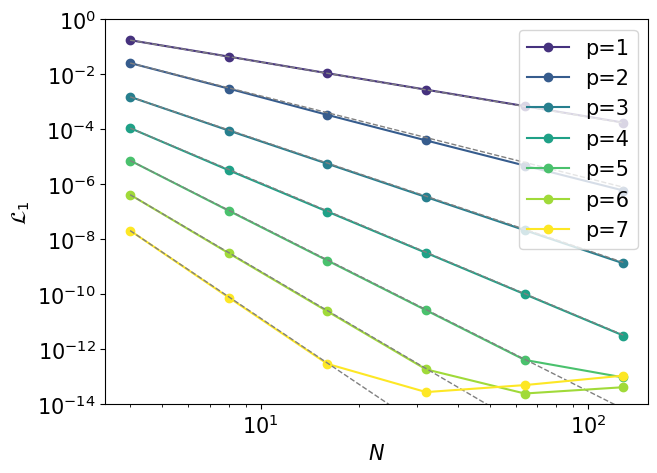

In [28]:
def compute_error(s):
    na=np.newaxis
    dx = (s.x_fp[1:]-s.x_fp[:-1])/s.N
    diff = np.abs(s.U_cv-s.U_init_cv)
    diff *= dx[na,:]
    diff=squash_dimensions(diff)
    return math.fsum((diff).ravel())

for p in range(1,8):
    errors=[]
    for N in Ns:
        errors.append(compute_error(sims[(p,N)]))
    loglog(Ns,errors,"-o",color=cm.viridis(p/7),label=f"p={p}")
    plot(Ns,errors[0]*(Ns[0]/Ns)**(p+1), ls="--", color="gray", lw=1)
ylim(1e-14,1)
ylabel(r"$\mathcal{L}_1$")
xlabel(r"$N$")
legend()      

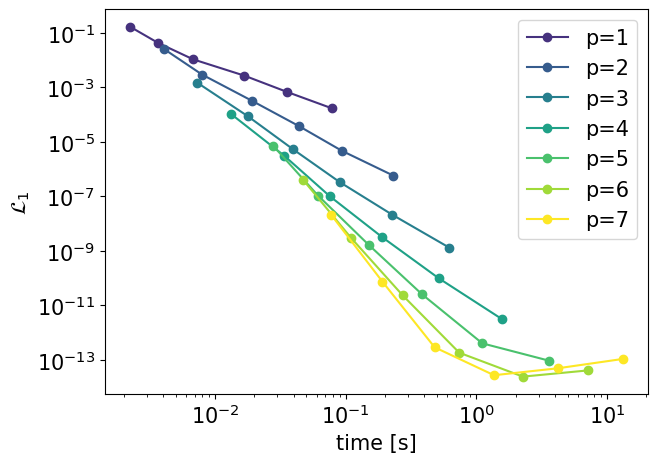

In [29]:
for p in range(1,8):
    errors=[]
    times=[]
    for N in Ns:
        errors.append(compute_error(sims[(p,N)]))
        times.append(sims[(p,N)].execution_time)
    loglog(times,errors,"-o",color=cm.viridis(p/7),label=f"p={p}")
ylabel(r"$\mathcal{L}_1$")
xlabel(r"time [s]")
legend()

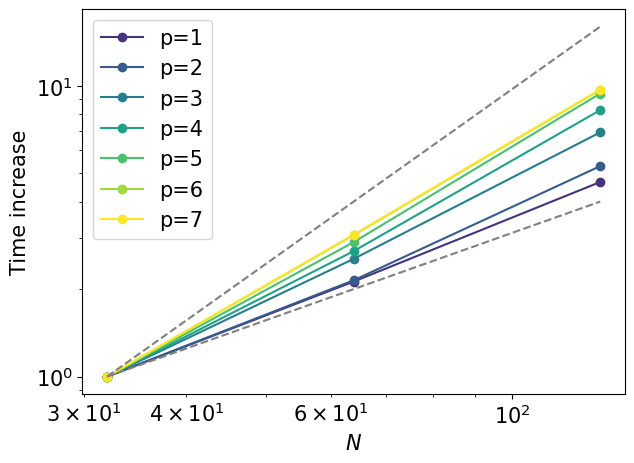

In [30]:
Ns=2**arange(5,8)
for p in range(1,8):
    times=[]
    for N in Ns:
        times.append(sims[(p,N)].execution_time)
    times=array(times)
    loglog(Ns,times/times[0],"-o",color=cm.viridis(p/7),label=f"p={p}")
plot(Ns,(Ns/Ns[0])**2,ls="--",color="gray")
plot(Ns,(Ns/Ns[0])**1,ls="--",color="gray")
ylabel(r"Time increase")
xlabel(r"$N$")
legend()

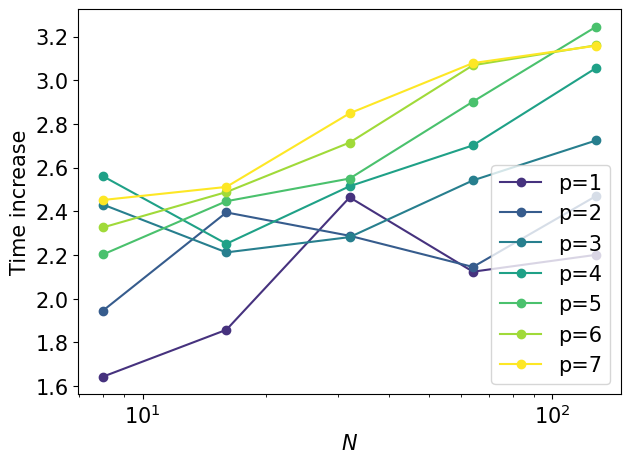

In [31]:
Ns=2**arange(2,8)
for p in range(1,8):
    times=[]
    for N in Ns:
        times.append(sims[(p,N)].execution_time)
    times=array(times)
    plot(Ns[1:],times[1:]/times[:-1],"-o",color=cm.viridis(p/7),label=f"p={p}")
xscale("log")
ylabel(r"Time increase")
xlabel(r"$N$")

legend()

Increase in computational time due to doubling the resolution.

The increase in time trends towards $4\times$, this value is due to the doubling in elements and the doubling in time-steps to reach the same date (as $dt\propto1/N)$. 

p=1, N=12: 301 time steps (Execution time: 0.051038 s)
p=3, N=6: 301 time steps (Execution time: 0.112479 s)
p=7, N=3: 301 time steps (Execution time: 0.559766 s)


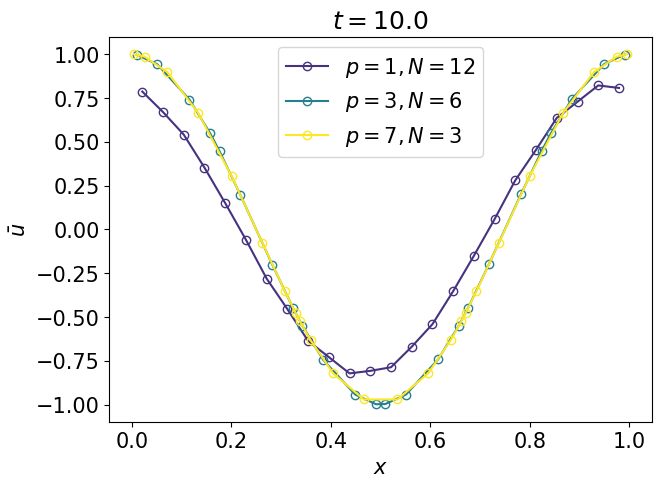

In [32]:
for p in [1,3,7]:
    N=24//(p+1)
    s = SD_Simulator(p=p,N=N,init_fct=sinus)
    perform_time_evolution(s,10)
    plot_solution(s,color=cm.viridis(p/7),label=f"$p={p}, N={N}$",marker="o",fillstyle="none")   
legend()

p=1, N=12: 3001 time steps (Execution time: 0.500622 s)
p=3, N=6: 3001 time steps (Execution time: 1.137953 s)
p=7, N=3: 3001 time steps (Execution time: 5.620997 s)


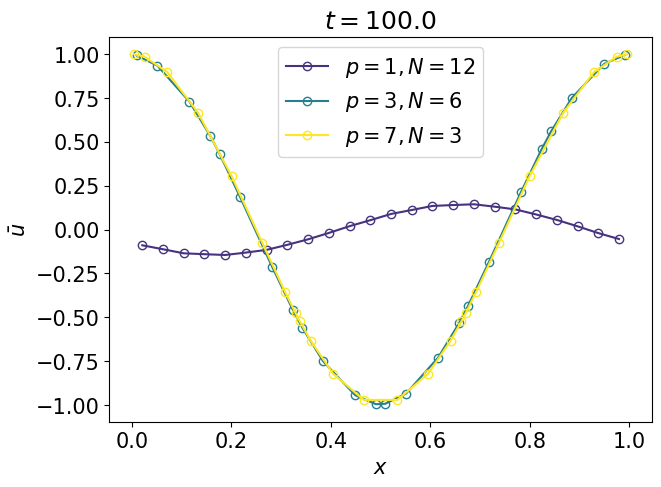

In [33]:
for p in [1,3,7]:
    N=24//(p+1)
    s = SD_Simulator(p=p,N=N,init_fct=sinus)
    perform_time_evolution(s,100)
    plot_solution(s,color=cm.viridis(p/7),label=f"$p={p}, N={N}$",marker="o",fillstyle="none")   
legend()

p=2, N=20: 76 time steps (Execution time: 0.025039 s)


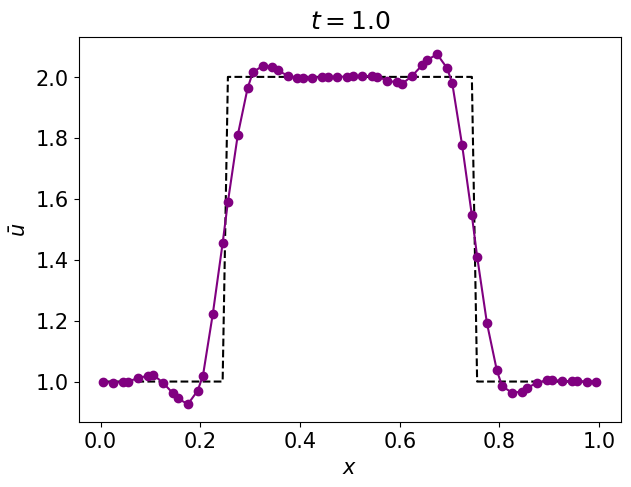

In [34]:
def step(x: np.ndarray,ivar: int) -> np.ndarray:
    if ivar==0:
        return np.where((x < 0.25) | (x > 0.75), 1.0, 2.0)
    elif ivar==1:
        return np.ones(x.shape)
    
s = SD_Simulator(p=2,N=20,init_fct=step)
plot_solution(s,color="k",ls="--")
perform_time_evolution(s,1)
plot_solution(s,marker="o",color="purple")

In [35]:
steps=defaultdict(list)
for p in range(1,8):
    s = SD_Simulator(p=p,N=10,init_fct=step)
    perform_time_evolution(s,1)
    steps[p] = s

p=1, N=10: 25 time steps (Execution time: 0.004699 s)
p=2, N=10: 38 time steps (Execution time: 0.013188 s)
p=3, N=10: 50 time steps (Execution time: 0.023533 s)
p=4, N=10: 63 time steps (Execution time: 0.044927 s)
p=5, N=10: 76 time steps (Execution time: 0.08407 s)
p=6, N=10: 88 time steps (Execution time: 0.152446 s)
p=7, N=10: 100 time steps (Execution time: 0.264715 s)


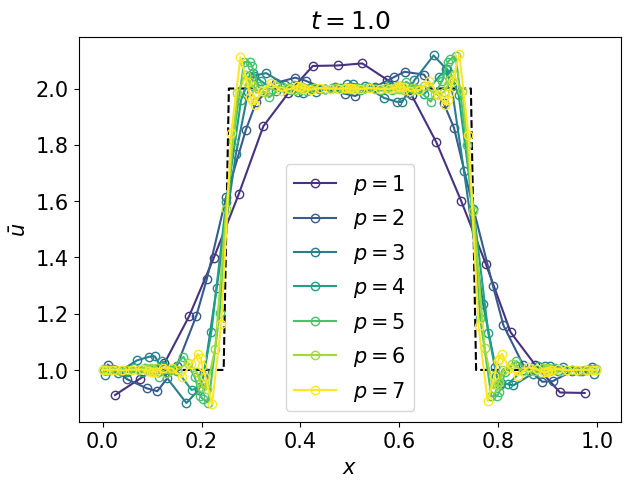

In [36]:
ref = SD_Simulator(p=2,N=20,init_fct=step)
plot_solution(ref,color="k",ls="--")
for p in range(1,8):
    plot_solution(steps[p],color=cm.viridis(p/7),label=f"$p={p}$",marker="o",fillstyle="none")   
legend()

In [37]:
for p in [1,3,7]:
    N=80//(p+1)
    s = SD_Simulator(p=p,N=N,init_fct=step)
    perform_time_evolution(s,1)
    steps[(p,N)] = s

p=1, N=40: 100 time steps (Execution time: 0.021758 s)
p=3, N=20: 100 time steps (Execution time: 0.050299 s)
p=7, N=10: 100 time steps (Execution time: 0.25191 s)


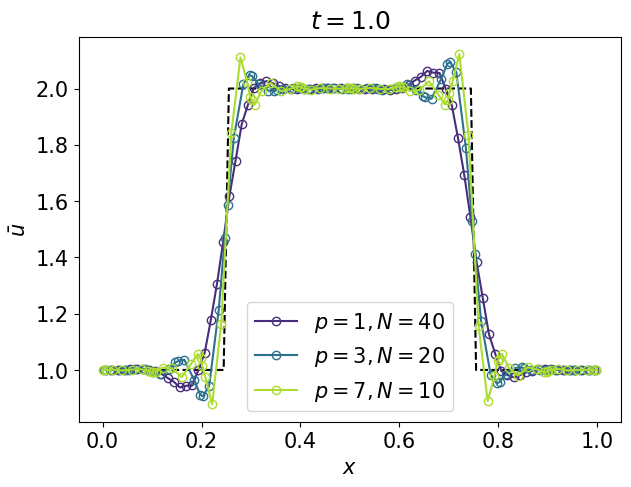

In [38]:
plot_solution(ref,color="k",ls="--")
for p in [1,3,7]:
    N=80//(p+1)
    plot_solution(steps[(p,N)],color=cm.viridis(p/8),label=f"$p={p}, N={N}$",marker="o",fillstyle="none")   
legend()

In [39]:
for p in [1,3,7]:
    N=80//(p+1)
    s = SD_Simulator(p=p,N=N,init_fct=step)
    perform_time_evolution(s,10)
    steps[(p,N)] = s

p=1, N=40: 1001 time steps (Execution time: 0.20898 s)
p=3, N=20: 1001 time steps (Execution time: 0.503172 s)
p=7, N=10: 1001 time steps (Execution time: 2.501357 s)


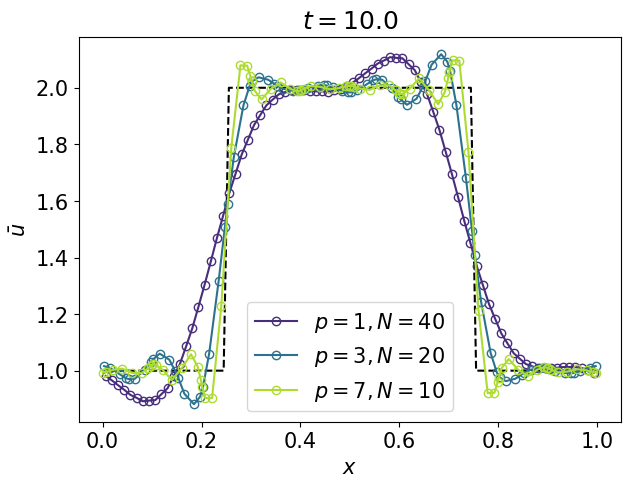

In [40]:
plot_solution(ref,color="k",ls="--")
for p in [1,3,7]:
    N=80//(p+1)
    plot_solution(steps[(p,N)],color=cm.viridis(p/8),label=f"$p={p}, N={N}$",marker="o",fillstyle="none")   
legend()

In [41]:
for p in [1,3,7]:
    N=80//(p+1)
    s = SD_Simulator(p=p,N=N,init_fct=step)
    perform_time_evolution(s,100)
    steps[(p,N)] = s

p=1, N=40: 10000 time steps (Execution time: 2.120303 s)
p=3, N=20: 10000 time steps (Execution time: 5.037209 s)
p=7, N=10: 10000 time steps (Execution time: 25.175204 s)


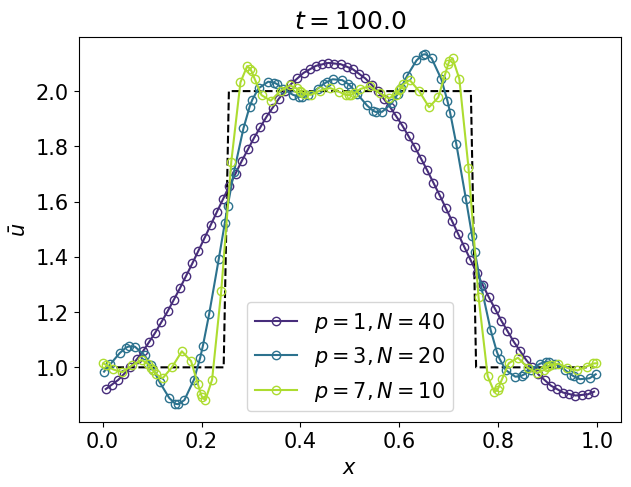

In [42]:
plot_solution(ref,color="k",ls="--")
for p in [1,3,7]:
    N=80//(p+1)
    plot_solution(steps[(p,N)],color=cm.viridis(p/8),label=f"$p={p}, N={N}$",marker="o",fillstyle="none")   
legend()

In [43]:
p=1
for i in range(3):
    N=80*2**i
    s = SD_Simulator(p=p,N=N,init_fct=step)
    perform_time_evolution(s,100)
    steps[(p,N)] = s

p=1, N=80: 20001 time steps (Execution time: 4.66064 s)
p=1, N=160: 40001 time steps (Execution time: 10.353394 s)
p=1, N=320: 80001 time steps (Execution time: 25.302592 s)


25.302592369000195
5.037208570000075
25.17520432799938


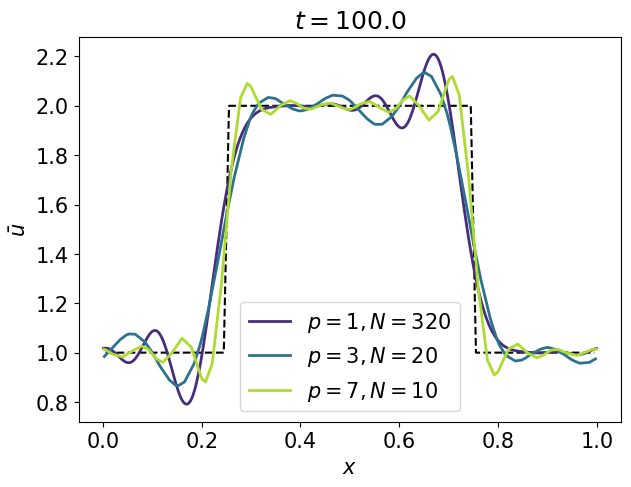

In [44]:
plot_solution(ref,color="k",ls="--")
ps=[1,3,7]
Ns=[320,20,10]
for i in range(3):
    p,N = ps[i],Ns[i]
    plot_solution(steps[(p,N)],color=cm.viridis(p/8),label=f"$p={p}, N={N}$",lw=2)
    print(steps[(p,N)].execution_time)
legend()

p=2, N=80: 301 time steps (Execution time: 0.126723 s)


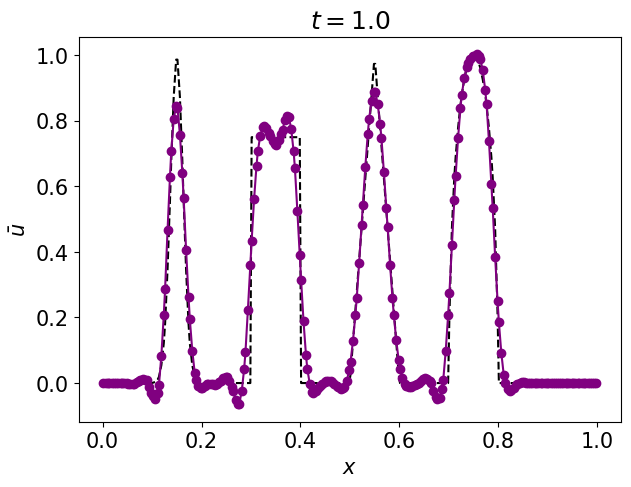

In [45]:
def composite(x: np.ndarray, ivar: int) -> np.ndarray:
    if ivar== 0:
        return np.where(
            (x >= 0.1) & (x <= 0.2),
            (
                np.exp(-np.log(2.0)/36.0/0.0025**2.0 * (x - 0.0025 - 0.15)**2.0)
                + np.exp(-np.log(2.0)/36.0/0.0025**2.0 * (x + 0.0025 - 0.15)**2.0)
                + 4.0*np.exp(-np.log(2.0)/36.0/0.0025**2.0 * (x - 0.15)**2.0)
            )/6.0,
            np.where(
                (x >= 0.3) & (x <= 0.4),
                0.75,
                np.where(
                    (x >= 0.5) & (x <= 0.6),
                    1.0 - np.abs(20.0*(x - 0.55)),
                    np.where(
                        (x >= 0.7) & (x <= 0.8),
                        (
                            np.sqrt(np.maximum(1.0 - (20.0*(x - 0.75 - 0.0025))**2.0, 0.0))
                            + np.sqrt(np.maximum(1.0 - (20.0*(x - 0.75 + 0.0025))**2.0, 0.0))
                            + 4.0*np.sqrt(np.maximum(1.0 - (20.0*(x - 0.75))**2.0, 0.0))
                        )/6.0,
                        0.0,
                    ),
                ),
            ),
        )
    elif ivar==1:
        return np.ones(x.shape)
    else:
        return np.zero(x.shape)
    
s = SD_Simulator(p=2,N=80,init_fct=composite)
plot_solution(s,color="k",ls="--")
perform_time_evolution(s,1)
plot_solution(s,marker="o",color="purple")

In [46]:
comps=defaultdict(list)
comp_ref = SD_Simulator(p=2,N=80,init_fct=composite)
for p in [1,3,7]:
    N=128//(p+1)
    s = SD_Simulator(p=p,N=N,init_fct=composite)
    perform_time_evolution(s,1)
    comps[(p,N)] = s

p=1, N=64: 161 time steps (Execution time: 0.03593 s)
p=3, N=32: 161 time steps (Execution time: 0.090508 s)
p=7, N=16: 161 time steps (Execution time: 0.481677 s)


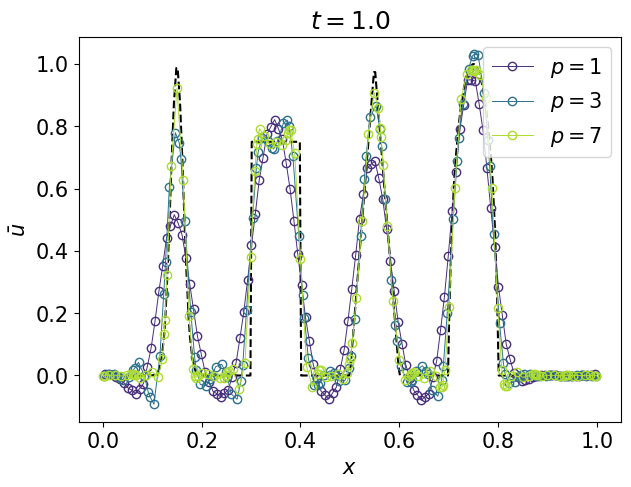

In [47]:
plot_solution(comp_ref,color="k",ls="--")
for p in [1,3,7]:
    N=128//(p+1)
    plot_solution(comps[(p,N)],color=cm.viridis(p/8),label=f"$p={p}$",marker="o",fillstyle="none",lw=.7)   
legend()

In [48]:
for p in [1,3,7]:
    N=128//(p+1)
    perform_time_evolution(comps[(p,N)],10)

p=1, N=64: 1602 time steps (Execution time: 0.318553 s)
p=3, N=32: 1602 time steps (Execution time: 0.833015 s)
p=7, N=16: 1602 time steps (Execution time: 4.415276 s)


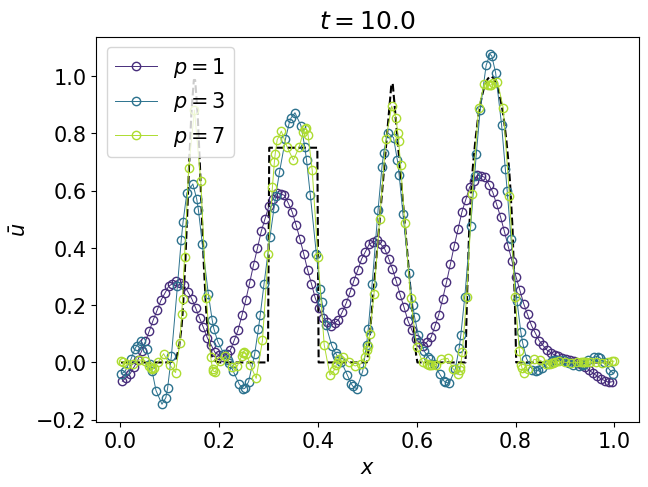

In [49]:
plot_solution(comp_ref,color="k",ls="--")
for p in [1,3,7]:
    N=128//(p+1)
    plot_solution(comps[(p,N)],color=cm.viridis(p/8),label=f"$p={p}$",marker="o",fillstyle="none",lw=.7)   
legend()